
# Wikipedia Analysis


This notebook performs analysis and classification of an educational dataset containing Wikipedia articles, exploiting NLP and machine learning techniques. <br> <br>
The dataset is composed of 4 columns: 
* **title**: Title of the article
* **summary**: Introduction of the article
* **documents**: Full article
* **categoria**: Category associated with the article

The articles within the dataset are divided into the following categories:
* 'culture',
* 'economics',
* 'energy',
* 'engineering',
* 'finance',
* 'humanities',
* 'medicine',
* 'pets',
* 'politics',
* 'research',
* 'science',
* 'sports',
* 'technology',
* 'trade',
* 'transport'

For each category, the following information are extracted:
* Number of articles
* Average number of words used
* Maximum number of words in the longest article
* Minimum number of words in the shortest article
* Word cloud of the most representative words

The data are loaded and preprocessed to remove null values and empty strings. Then, a processing pipeline with tokenization, word embedding, PCA and logistic regression is trained and evaluated using first only the summaries and then the whole articles to predict the related categories, comparing which methods yield better results.  
Resource optimization is achieved by reducing data dimensionality and the maximum number of words. Due to limited computational resources, only 25% of the total data has been used to avoid exceeding the maximum single operation time of 1 hour allowed by Databricks Community Edition cluster.


## Sources

WordsCloud documentation: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud


## Libraries

In [0]:
# Libraries installation
!pip install spacy==3.7.5
!pip install nltk==3.8.1
!pip install wordcloud==1.9.3
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.4/922.4 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━

In [0]:
# Utility
import os
import re
from collections import defaultdict

# Data
import pandas as pd

# Plot
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Language
import spacy
import nltk
from nltk.corpus import stopwords

# Spark
from pyspark.sql.functions import col, explode, lower, split, udf, trim
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, Word2Vec, StringIndexer, StandardScaler, PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


## Constants and Global Variables

In [0]:
# Random seeds for reproducibility
RANDOM_SEED = 0

# Fraction of dataset to keep for model construction due to limited resources
DATA_KEEP_RATIO = 0.25

# Ratio for test data for train-test split
TEST_SIZE_RATIO = 0.2

# Dimensionality for word vectorization
WORD_VECTOR_SIZE = 100

# Minimum number of occurrences for a word to be included in the vocabulary
WORD_MINIMUM_COUNT = 10

# Number of components for PCA
PCA_COMPONENTS = 10


## 1 - Exploratory Data Analysis

In [0]:
# Download the dataset if not done yet
if not os.path.isfile("wikipedia.csv"):
    !wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv

# Load the dataset in Pandas dataframe
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')

# Create a Spark dataframe from Pandas dataframe
spark_df = spark.createDataFrame(dataset)

# Remove unuseful column
spark_df = spark_df.drop('Unnamed: 0')

# Convert the dataframe to a Spark table available for SQL queries
spark_df.write.mode('overwrite').saveAsTable("wikipedia")

--2024-06-10 17:13:57--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.154.72, 3.5.224.208
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.154.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘wikipedia.csv’

wikipedia.csv       100%[===================>] 956.99M  18.5MB/s    in 65s     

2024-06-10 17:15:03 (14.7 MB/s) - ‘wikipedia.csv’ saved [1003477941/1003477941]



In [0]:
%sql

-- Preview the first 5 records in the table
select * from wikipedia limit 5

title summary documents categoria economics economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. definitions of economics over time the earlier term for the discipline was 'political economy', but since the late 19th century, it has commonly been called 'economics'. the term is ultimately derived from ancient greek οἰκονομία (oikonomia) which is a term for the "way (nomos) to run a household (oikos)", or in other words the know-how of an οἰκονομικός (oikonomikos), or "household or homestead manager". derived terms such as "economy" can therefore often mean "frugal" or "thrifty". by extension then, "political economy" was the way to manage a polis or state. there are a variety of modern definitions of economics; some reflect evolving views of the subject or different views among economists. scottish philosopher adam smith (1776) defined what was then called political economy as "an inquiry into the nature and causes of the wealth of nations", in particular as: a branch of the science of a statesman or legislator [with the twofold objectives of providing] a plentiful revenue or subsistence for the people ... [and] to supply the state or commonwealth with a revenue for the publick services. jean-baptiste say (1803), distinguishing the subject matter from its public-policy uses, def

In [0]:
%sql

-- Check how many values are not present for each fields
select
    sum(case when title     is null then 1 else 0 end) as null_count_title,
    sum(case when summary   is null then 1 else 0 end) as null_count_summary,
    sum(case when documents is null then 1 else 0 end) as null_count_documents,
    sum(case when categoria is null then 1 else 0 end) as null_count_categoria
from wikipedia


null_count_title null_count_summary null_count_documents null_count_categoria 0 928 928 0

In [0]:
# Obtain all unique values for field 'categoria'
unique_categories_df = spark.sql("""select distinct categoria from wikipedia""")

In [0]:
# Extract categories and collect them in a ordered list
unique_categories = sorted([row.categoria for row in unique_categories_df.collect()])
unique_categories

['culture',
 'economics',
 'energy',
 'engineering',
 'finance',
 'humanities',
 'medicine',
 'pets',
 'politics',
 'research',
 'science',
 'sports',
 'technology',
 'trade',
 'transport']


#### 1.1 - Number of Articles for Each Category

In [0]:
%sql

-- Display the number of articles for each category
select
    categoria,
    count(*) as number_articles_per_category
from wikipedia
group by categoria

categoria number_articles_per_category finance 10157 energy 10046 culture 10372 science 10236 politics 11358 economics 10110 humanities 10236 medicine 10076 sports 10068 engineering 10220 technology 10095 transport 10130 pets 10023 research 10037 trade 10068


#### 1.2 - Position Indexes for Number of Words for Each Category

In [0]:
# Display average, maximum and minimum number of words among articles for each category
sql_result = spark.sql("""
                        select
                            categoria,

                            -- Calculate the average of words counts and round to nearest integer number
                            int(round(avg(words_count))) as average_words_per_article,

                            -- Maximum number of words count
                            max(words_count) as maximum_number_of_words_in_article,

                            -- Minimum number of words count
                            min(words_count) as minimum_number_of_words_in_article
                        from (
                            select
                                categoria,
                                -- Split available documents into words and count them
                                size(split(documents, ' ')) as words_count
                            from wikipedia
                            where documents is not null and documents != ''
                        )
                        group by categoria
                    """)
sql_result.show()

+-----------+-------------------------+----------------------------------+----------------------------------+
|  categoria|average_words_per_article|maximum_number_of_words_in_article|minimum_number_of_words_in_article|
+-----------+-------------------------+----------------------------------+----------------------------------+
|    finance|                     1910|                             33479|                                 3|
|     energy|                      587|                             23223|                                 9|
|    culture|                      654|                             15538|                                11|
|    science|                     1876|                             29419|                                15|
|   politics|                     1516|                             20140|                                11|
|  economics|                      984|                             24022|                                10|
| humaniti


#### 1.3 - Word Clouds for Each Category

In [0]:
def remove_stopwords(text, stopwords):
    """ Remove stopwords from input text and return processed text """

    # Split input text
    words = text.split()

    # Remove words if among stopwords 
    filtered_words = [word for word in words if word not in stopwords]

    # Concatenate again the input text
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text


def lemmatize_text(text, lemmatizer):
    """ Apply lemmatization to input text and return processed text """

    # Split input text
    words = text.split()

    # Apply lemmatization to each word
    lemma_words = []
    for word in words:
        lemma_words.append(lemmatizer.lemmatize(word))

    # Concatenate again the input text
    lemma_text = ' '.join(lemma_words)
    
    return lemma_text

In [0]:
def elaborate_text_for_NLP(text):
    """ Preprocess the input text applying globally defined stopwords and lemmatizer.
    Return a text compliant for language processing """

    # Set global NLP objects
    global stopwords_eng, lemmatizer

    # Handle null text
    if text is not None:

        # Normalize to lower case
        text = text.lower()

        # Remove newline and tabulation characters
        regex_newline_tab = r'[\n\t]'
        text = re.sub(regex_newline_tab, ' ', text)

        # Keep alphanumeric characters, spaces and apostrophes - Remove tags, URLs and hyperlinks
        regex_unicode = re.compile(r"([^0-9A-Za-z' ])|(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|http.+?")
        text = re.sub(regex_unicode, ' ', text)

        # Remove stopwords from the dataset
        text = remove_stopwords(text, stopwords_eng)

        # Apply lemmatization
        text = lemmatize_text(text, lemmatizer)
    
    else:

        # Set empty string
        text = ""

    return text

In [0]:
def create_preprocessed_words_count_dictionary(texts):
    """ Generate a dictionary from an input text mapping word and related frequency as key and value """

    # Initilize words count dictionary (defaultdict type to easily handle new words insertion)
    words_count = defaultdict(int)

    # Cycle each text
    for text in texts:

        # Preprocess the text
        text_preprocessed = elaborate_text_for_NLP(text)

        # Split the text in single words
        words = text_preprocessed.split()

        # Cycle each word
        for word in words:

            # Add the word in the dictionary incrementing the related frequency
            words_count[word] += 1

    # Order the dictionary and convert it to standard type
    words_count = dict(sorted(words_count.items(), key = lambda item: item[1], reverse = True))

    return words_count

In [0]:
# Group and concatenate all documents in a list of strings for each category
documents_by_category_df = spark.sql("""
                        select 
                            categoria,
                            collect_list(documents) as all_documents 
                        from wikipedia 
                        group by categoria
                    """)

In [0]:
# Download and select english stopwords to be removed from texts
nlp = spacy.load("en_core_web_sm")
stopwords_eng = nlp.Defaults.stop_words

# Download lexical database
nltk.download('wordnet')
nltk.download('omw-1.4')

# Istantiate the lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [0]:
# Create dictionary for words count for each category
words_counts_by_category_dict = {}

# Cycle each row in the dataframe containing all documents grouped by category
for row in documents_by_category_df.collect():

    # Set the category for current row
    category = row['categoria']

    # Set the documents list for current row
    all_documents = row['all_documents']

    # Insert words count for current category
    words_counts_by_category_dict[category] = create_preprocessed_words_count_dictionary(all_documents)

In [0]:
# Show most frequent words by category
for category, words_count in words_counts_by_category_dict.items():

    # Select and show top 10 frequent words
    top_words = dict(list(words_count.items())[:10])
    print(f"Category: {category}")

    # Cycle all words and related frequencies
    for i, (word, frequency) in enumerate(top_words.items()):
        print(f"{i + 1} - {word}: {frequency}")
    print('\n')

Category: finance
1 - series: 90158
2 - man: 72591
3 - company: 56927
4 - master: 46538
5 - new: 42708
6 - universe: 41935
7 - time: 38948
8 - voiced: 34919
9 - power: 33689
10 - cartoon: 32551


Category: medicine
1 - hospital: 64669
2 - health: 28909
3 - medical: 27545
4 - new: 26046
5 - university: 25422
6 - medicine: 20825
7 - research: 20198
8 - school: 16156
9 - center: 15146
10 - american: 15021


Category: research
1 - research: 48633
2 - university: 38875
3 - medical: 24447
4 - science: 22511
5 - health: 20874
6 - institute: 19366
7 - medicine: 17932
8 - award: 16663
9 - study: 16239
10 - national: 15304


Category: energy
1 - power: 85240
2 - station: 46298
3 - plant: 40957
4 - company: 32660
5 - energy: 31670
6 - electricity: 26310
7 - mw: 21315
8 - 1: 21145
9 - gas: 19793
10 - unit: 18961


Category: technology
1 - game: 49554
2 - system: 27887
3 - version: 25084
4 - user: 22230
5 - linux: 21973
6 - 2: 21525
7 - software: 20946
8 - new: 20362
9 - released: 20162
10 - 1: 199

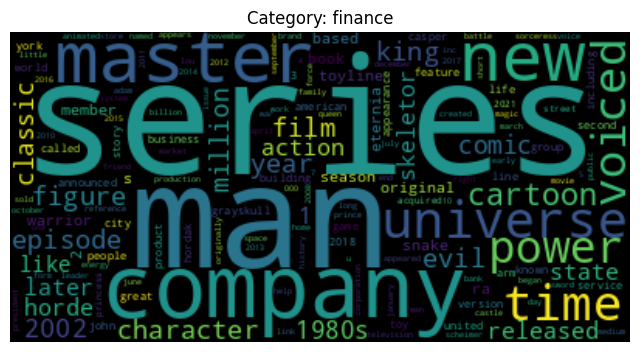

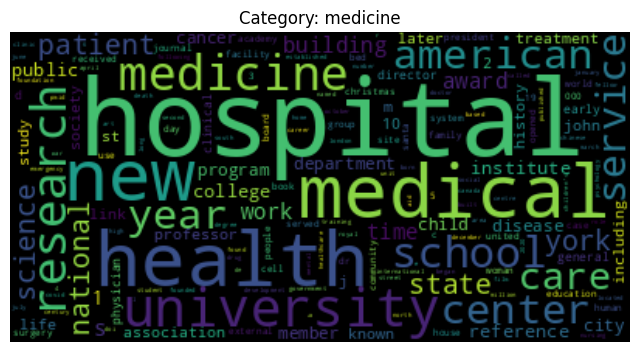

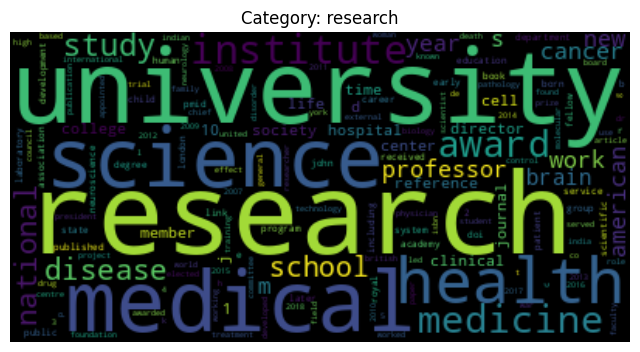

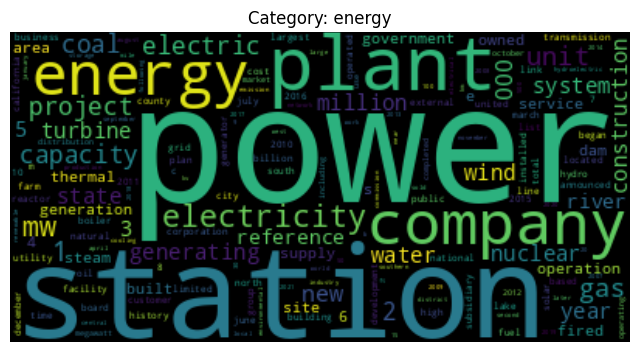

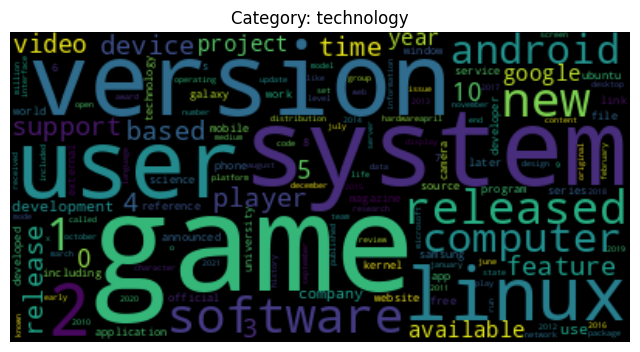

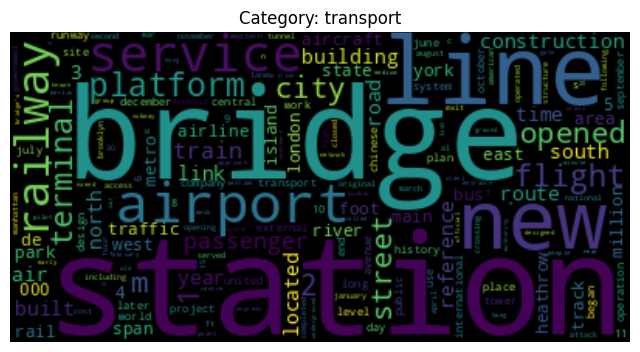

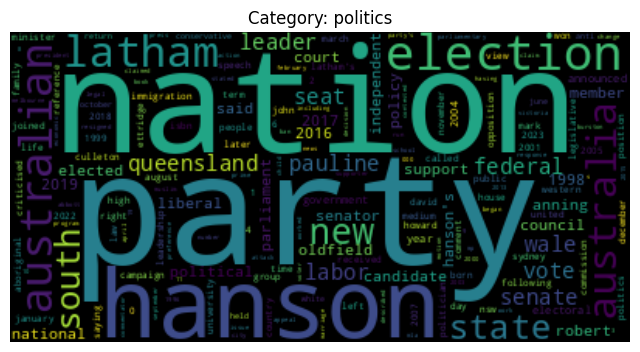

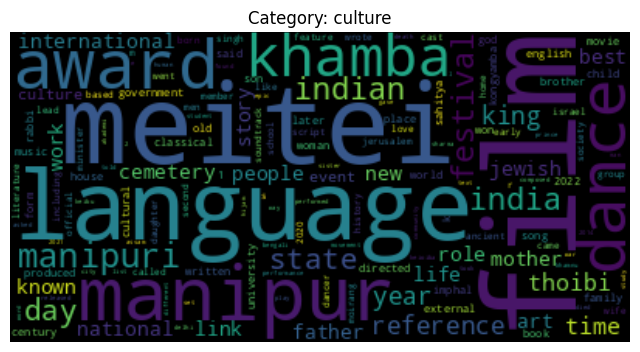

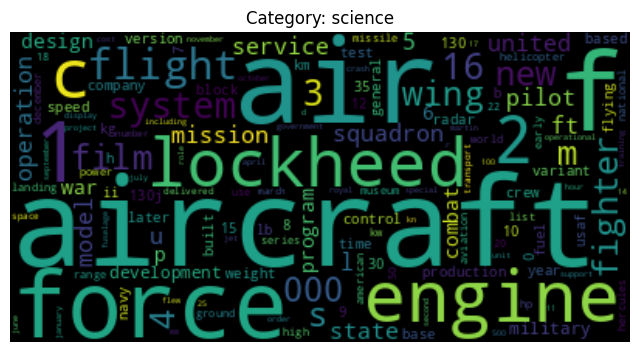

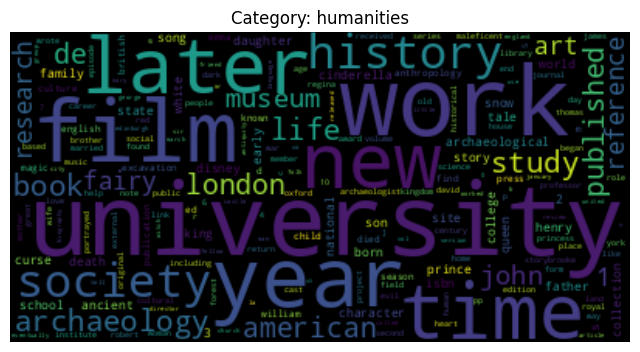

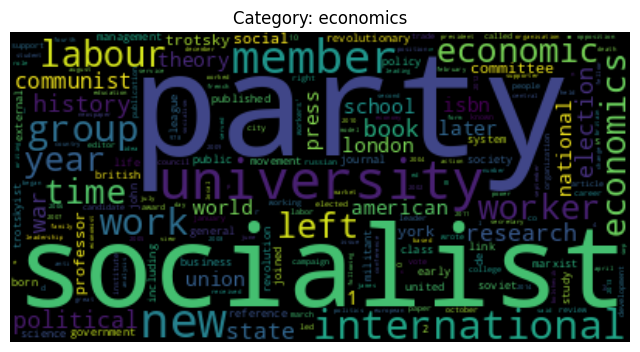

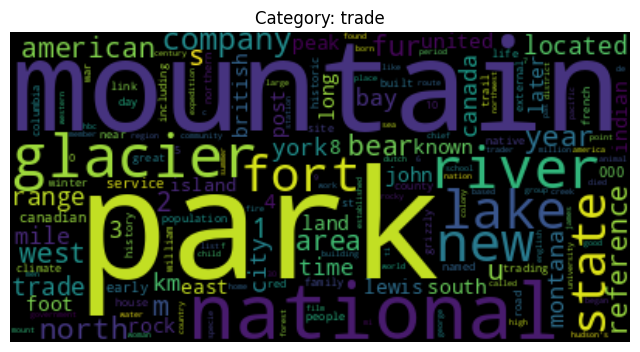

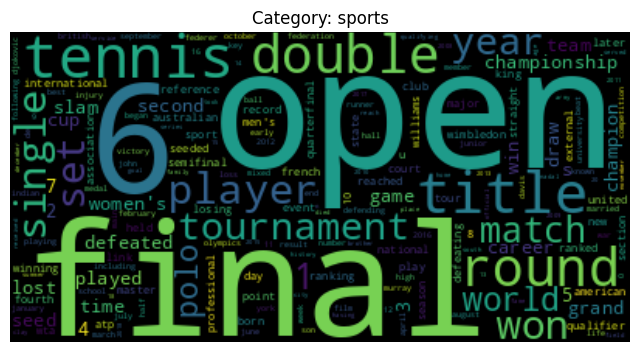

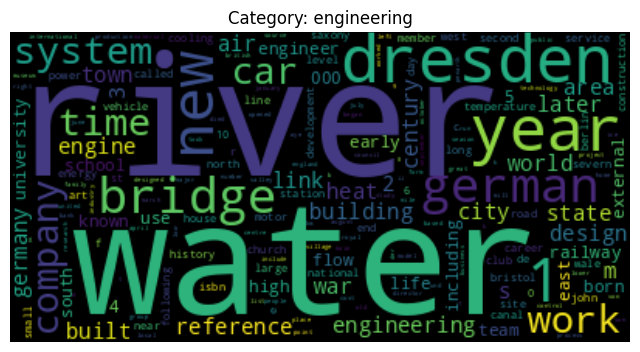

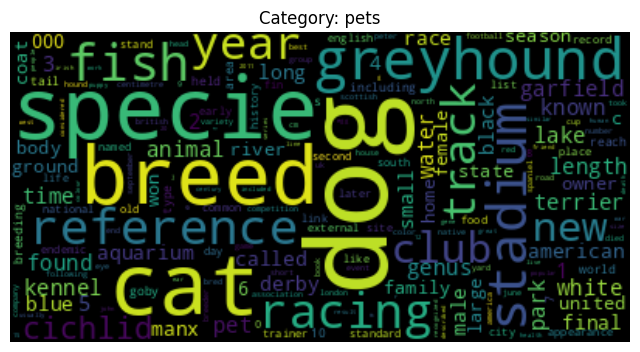

In [0]:
# Show most frequent words by category
for category, words_count in words_counts_by_category_dict.items():

    # Generate a word cloud image
    wordcloud = WordCloud().generate_from_frequencies(words_count)

    # Display the generated image
    plt.figure(figsize = (8, 6))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(f"Category: {category}")
    plt.axis("off")
    plt.show()


## 2 - Category Classifier


After applying the same preprocessing used to produce the word clouds, two simple logistic regressors are trained, first using the summaries and then the documents. As indicated at the beginning, it is necessary to limit the data to 25% of the total beforehand.

In [0]:
# Fetch features and target from the table excluding null, empty and only-spaces strings among features
df_spark = spark.sql("""
                            select
                                summary,
                                documents,
                                categoria
                            from wikipedia
                            where trim(summary) is not null and trim(summary) != ""
                            and trim(documents) is not null and trim(documents) != ""
                        """)

In [0]:
# Reduce data due to limited computational resources in Databricks Community Edition
df_spark, _ = df_spark.randomSplit([DATA_KEEP_RATIO, 1 - DATA_KEEP_RATIO], seed = RANDOM_SEED)

In [0]:
# Show the dataframe
display(df_spark.limit(10))

summary documents categoria "ask for more" is a song performed by janet jackson as part of an advertising campaign for soft drink company pepsi in 1999. alternate versions of the ad campaign with ricky martin and aaron kwok were released in international markets. "ask for more" is a song performed by janet jackson as part of an advertising campaign for soft drink company pepsi in 1999. alternate versions of the ad campaign with ricky martin and aaron kwok were released in international markets. song information "ask for more" was a promotional single by janet jackson for pepsi, released on january 1, 1999. jackson commented on the collaboration with pepsi saying "aside from being associated with many amazing artists over the years, pepsi is very honest and passionate when it comes to spreading a positive message like 'ask for more'".the campaign was launched as a re-branding for pepsi internationally. alternate versions of the campaign also co-starred hong kong singer aaron kwok for the asian market and aired in china, and latino singer ricky martin for the latin market and aired in latin america. a duet version of the song performed in spanish by jackson and martin was also aired in europe as part of the commercial campaign. a full length promotional music video of the version with kwok was released in asian markets. the original version of the ad features model and dancer rob vinson. dancers tina landon and shawnette heard appear in all versions of the ad along with jackson.the single was only released as a promotional recording. consumers were able to receive a free cd of the song with the purchase of pepsi products during the promotional campaign in 1999. track listings u.s. promo cd single (61369427avrm) and u.k. promo cd single (61369427avrm) "ask for more" – 5:49 interview – 4:50 "ask for more" (remix) – 8:05u.k. 12" promo "ask for more" (masters at work remix) – 8:05 official remixes single version – 5:49 vocal-up full version – 5:49 masters at work remix – 8:05 references external links ask for more (pepsi ad) ask for more (ad campaign with ricky martin) ask for more (ad campaign with aaron kwok) ask for more (pepsi interview) ask for more (behind the scenes) finance "cola" is a song by american singer and songwriter lana del rey, taken from her third extended play, paradise (2012), and the reissue of her second studio album, born to die: the paradise edition (2012). "cola" first appeared in a teaser trailer posted to her official youtube account as a snippet. the lyrics were considered controversial, causing major media outlets to respond. "cola" is a song by american singer and songwriter lana del rey, taken from her third extended play, paradise (2012), and the reissue of her second studio album, born to die: the paradise edition (2012). "cola" first appeared in a teaser trailer posted to her official youtube account as a snippet. the lyrics were considered controversial, causing major media outlets to respond. track "cola" has been described as a "gritty art pop" song. it was written by elizabeth grant and rick nowels, with grant writing lyrics for the song. when del rey was asked about the origin of the lyrics, she explained: "my [then]-boyfriend is scottish; he deems american girls very exotic. he once told me, 'you american girls walk around as if your pussies tasted like pepsi-cola, as if you'd wrap yourself into an american flag to sleep.' he deems us all very patriotic." it was produced by nowels, with co-production handled by the production group dk. the arrangement consists of drum machines programmed by kieron menzies, who was also recording engineer, real drums performed by devrim karaoglu and nowels, keyboards, juno bass and acoustic guitar also played by nowels, slide guitar performed by tim pierce, and strings, glockenspiel, brass, organ, electric guitar, piano and synthesizers played by patrick warren. the song was recorded at the green building in santa monica, with chris garcia and jordan stilwell 

In [0]:
# Register NLP preprocess function
elaborate_NLP_udf = udf(elaborate_text_for_NLP, StringType())

# Apply NLP preprocessing to summaries
df_spark_preprocessed = df_spark.withColumn('summary', elaborate_NLP_udf(df_spark['summary']))

# Apply NLP preprocessing to documents
df_spark_preprocessed = df_spark_preprocessed.withColumn('documents', elaborate_NLP_udf(df_spark['documents']))

In [0]:
# Show the preprocessed dataframe
display(df_spark_preprocessed.limit(10))

summary documents categoria ask song performed janet jackson advertising campaign soft drink company pepsi 1999 alternate version ad campaign ricky martin aaron kwok released international market ask song performed janet jackson advertising campaign soft drink company pepsi 1999 alternate version ad campaign ricky martin aaron kwok released international market song information ask promotional single janet jackson pepsi released january 1 1999 jackson commented collaboration pepsi saying aside associated amazing artist year pepsi honest passionate come spreading positive message like 'ask more' campaign launched branding pepsi internationally alternate version campaign co starred hong kong singer aaron kwok asian market aired china latino singer ricky martin latin market aired latin america duet version song performed spanish jackson martin aired europe commercial campaign length promotional music video version kwok released asian market original version ad feature model dancer rob vinson dancer tina landon shawnette heard appear version ad jackson single released promotional recording consumer able receive free cd song purchase pepsi product promotional campaign 1999 track listing u s promo cd single 61369427avrm u k promo cd single 61369427avrm ask 5 49 interview 4 50 ask remix 8 05u k 12 promo ask master work remix 8 05 official remixes single version 5 49 vocal version 5 49 master work remix 8 05 reference external link ask pepsi ad ask ad campaign ricky martin ask ad campaign aaron kwok ask pepsi interview ask scene finance cola song american singer songwriter lana del rey taken extended play paradise 2012 reissue second studio album born die paradise edition 2012 cola appeared teaser trailer posted official youtube account snippet lyric considered controversial causing major medium outlet respond cola song american singer songwriter lana del rey taken extended play paradise 2012 reissue second studio album born die paradise edition 2012 cola appeared teaser trailer posted official youtube account snippet lyric considered controversial causing major medium outlet respond track cola described gritty art pop song written elizabeth grant rick nowels grant writing lyric song del rey asked origin lyric explained boyfriend scottish deems american girl exotic told 'you american girl walk pussy tasted like pepsi cola you'd wrap american flag sleep ' deems patriotic produced nowels co production handled production group dk arrangement consists drum machine programmed kieron menzies recording engineer real drum performed devrim karaoglu nowels keyboard juno bass acoustic guitar played nowels slide guitar performed tim pierce string glockenspiel brass organ electric guitar piano synthesizer played patrick warren song recorded green building santa monica chris garcia jordan stilwell additional recording john davis finally mastering track metropolis mastering london song stage referred title pussy according registration american society composer author publisher ascap harry fox agency following release ride september 25 2012 del rey uploaded trailer containing snippet song new paradise ep paradise edition born die clip sings pussy taste like pepsi cola eye wide like cherry pie trailer edition new track listing cola referred alternative title pussy final version paradise ep born die paradise edition listed cola november 14 2012 digital spy announced del rey releasing song ep's second single defending track said record label reservation releasing harvey weinstein's sexual harassment assault allegation gained widespread public notoriety 2017 speculation lyric harvey's sky diamond reference weinstein's alleged illicit sexual activity involving female star response del rey cut song setlist la moon tour stating harvey weinstein harry winston type character mind wrote song lyric reference 1967 song lucy sky diamond beatles critical reception cola received polarized review fresh reaction lyric included cola hindustan time criticized song snip

In [0]:
# Train-Test split
train, test = df_spark_preprocessed.randomSplit([1 - TEST_SIZE_RATIO, TEST_SIZE_RATIO], seed = RANDOM_SEED)


#### 2.1 - Classification Based on Summary

In [0]:
# Pipeline creation
pipe_summary = Pipeline(stages = [
    
    # Words tokenization
    Tokenizer(inputCol = 'summary', outputCol = "tokens"),

    # Word2Vec embeddings
    Word2Vec(inputCol='tokens', outputCol = 'word2vec_vectors', vectorSize = WORD_VECTOR_SIZE, minCount = WORD_MINIMUM_COUNT),

    # Pre-Standardization
    StandardScaler(inputCol = 'word2vec_vectors', outputCol = "features_std_pre"),

    # Apply Principal-Components-Analysis to reduce features dimensionality
    PCA(k = PCA_COMPONENTS, inputCol =  'features_std_pre', outputCol = "features_pca"),

    # Post-Standardization (to avoid vanishing gradients)
    StandardScaler(inputCol = 'features_pca', outputCol = "features_std_post"),

    # Target encoding
    StringIndexer(inputCol = 'categoria', outputCol = "category_label"),

    # Logistic regression
    LogisticRegression(featuresCol = 'features_std_post', labelCol = 'category_label').setPredictionCol("summary_predictions")
])

In [0]:
# Model training with summary features
model_summary = pipe_summary.fit(train)

In [0]:
# Apply pipeline to test data and store in a dataframe
df_test_summary_predictions = model_summary.transform(test)

In [0]:
# Display predictions based on summaries
display(df_test_summary_predictions.limit(10))

summary documents categoria tokens word2vec_vectors features_std_pre features_pca features_std_post category_label rawPrediction probability summary_predictions 2008 red square demonstration political demonstration took place august 24 2008 lobnoe mesto moscow russia reference 1968 red square demonstration demonstration involved seven protester unfurling banner slogan freedom russian police arrived scene minute later police officer detained protester spectator tried destroy record event 2008 red square demonstration political demonstration took place august 24 2008 lobnoe mesto moscow russia reference 1968 red square demonstration demonstration involved seven protester unfurling banner slogan freedom russian police arrived scene minute later police officer detained protester spectator tried destroy record event historic context demonstration reference 1968 red square demonstration seven russian protested soviet occupation czechoslovakia warsaw pact invasion czechoslovakia 2008 demonstration organized express sentiment russian federation reverted soviet custom impression fueled inconsistency official notice published medium russo georgian war event aftermath noon 24 august 2008 protester unfurled banner reading freedom began shout slogan minute started explaining view spectator distributing notice answering question basic view protester included following political imprisonment restarted russia election prudent love country substituted love leader freedom created 1968 suppressed today dangerous express one's opinion blogger prosecuted police officer subsequently approached protester requested leave area protester complied began walking red square officer officer subsequently joined group protester handed banner police officer left red square dmitroshkin zboroshenko ninenko detained spectator took picture recorded video event picture video destroyed camera reported broken police journalist detained spectator elena kostyuchenko newspaper novaya gazeta ivan rusayev newspaper vedomosti dmitriy borko grani tv dmitriy shibayev newspaper new time detained individual sent kitai gorod police department police officer major selishev dealt 12 20pm journalist released kostuchenko insisted police officer state officially broken camera action detained person classified violation rule public event article 20 2 offence code russia following rule proceeding public protest reference external link 28 august 2008 archived original 2008 08 29 retrieved 31 august 2008 24 august 2008 retrieved 31 august 2008 25 august 2008 archived original 29 august 2008 retrieved 31 august 2008 40 24 august 2008 retrieved 31 august 2008 25 august 2008 retrieved 31 august 2008 25 august 2008 archived original 24 2011 retrieved 31 august 2008 25 august 2008 archived original 17 april 2013 retrieved 31 august 2008 25 august 2008 retrieved 31 august 2008 newsmsk com newsru 24 2008 video russian russian russian version wikinews ru 24 2008 finance List(2008, red, square, demonstration, political, demonstration, took, place, august, 24, 2008, lobnoe, mesto, moscow, russia, reference, 1968, red, square, demonstration, demonstration, involved, seven, protester, unfurling, banner, slogan, freedom, russian, police, arrived, scene, minute, later, police, officer, detained, protester, spectator, tried, destroy, record, event) Map(vectorType -> dense, length -> 100, values -> List(-0.017294638151259617, 0.1035712119029445, 0.06531830237052122, 0.03732003897515147, 0.0456795695909234, -0.07827717983597067, 0.037188352518823256, 0.015046153618239386, -0.02473585216631723, -0.009955759717931235, 0.0647431468850998, -0.02719183459263403, -0.02625836748196635, 0.019491611752485812, -0.059582597922620384, -0.13755186066724534, -0.004929893287331905, 0.08132653427851755, 0.030028379966266627, -0.05878635313968326, -0.16218342800722133, 0.07360349227349425, 0.005894047792914301, 0.09205703457565653, -0.05367696973993335, 0.042387688581203654, -0.03552413153527088, 0.03024343316724827, -

In [0]:
# Perfomance evaluation by accuracy
model_evaluator = MulticlassClassificationEvaluator(labelCol = 'category_label', predictionCol = 'summary_predictions', metricName = 'accuracy')

In [0]:
# Calculate the accuracy on test data
model_evaluator.evaluate(df_test_summary_predictions)

0.6989596879063719

In [0]:
# Perfomance evaluation by F1 score
model_evaluator = MulticlassClassificationEvaluator(labelCol = 'category_label', predictionCol = 'summary_predictions', metricName = 'f1')

In [0]:
# Calculate the F1 score on test data
model_evaluator.evaluate(df_test_summary_predictions)

0.6987881812227658


#### 2.2 - Classification Based on Documents

In [0]:
# Pipeline creation
pipe_document = Pipeline(stages = [
    
    # Words tokenization
    Tokenizer(inputCol = 'documents', outputCol = "tokens"),

    # Word2Vec embeddings
    Word2Vec(inputCol='tokens', outputCol = 'word2vec_vectors', vectorSize = WORD_VECTOR_SIZE, minCount = WORD_MINIMUM_COUNT),

    # Pre-Standardization
    StandardScaler(inputCol = 'word2vec_vectors', outputCol = "features_std_pre"),

    # Apply Principal-Components-Analysis to reduce features dimensionality
    PCA(k = PCA_COMPONENTS, inputCol =  'features_std_pre', outputCol = "features_pca"),

    # Post-Standardization (to avoid vanishing gradients)
    StandardScaler(inputCol = 'features_pca', outputCol = "features_std_post"),

    # Target encoding
    StringIndexer(inputCol = 'categoria', outputCol = "category_label"),

    # Logistic regression
    LogisticRegression(featuresCol = 'features_std_post', labelCol = 'category_label').setPredictionCol("document_predictions")

])

In [0]:
# Model training with document features
model_document = pipe_document.fit(train)

In [0]:
# Apply pipeline to test data and store in a dataframe
df_test_document_predictions = model_document.transform(test)

In [0]:
# Display predictions based on documents
display(df_test_document_predictions.limit(10))

summary documents categoria tokens word2vec_vectors features_std_pre features_pca features_std_post category_label rawPrediction probability document_predictions 2008 red square demonstration political demonstration took place august 24 2008 lobnoe mesto moscow russia reference 1968 red square demonstration demonstration involved seven protester unfurling banner slogan freedom russian police arrived scene minute later police officer detained protester spectator tried destroy record event 2008 red square demonstration political demonstration took place august 24 2008 lobnoe mesto moscow russia reference 1968 red square demonstration demonstration involved seven protester unfurling banner slogan freedom russian police arrived scene minute later police officer detained protester spectator tried destroy record event historic context demonstration reference 1968 red square demonstration seven russian protested soviet occupation czechoslovakia warsaw pact invasion czechoslovakia 2008 demonstration organized express sentiment russian federation reverted soviet custom impression fueled inconsistency official notice published medium russo georgian war event aftermath noon 24 august 2008 protester unfurled banner reading freedom began shout slogan minute started explaining view spectator distributing notice answering question basic view protester included following political imprisonment restarted russia election prudent love country substituted love leader freedom created 1968 suppressed today dangerous express one's opinion blogger prosecuted police officer subsequently approached protester requested leave area protester complied began walking red square officer officer subsequently joined group protester handed banner police officer left red square dmitroshkin zboroshenko ninenko detained spectator took picture recorded video event picture video destroyed camera reported broken police journalist detained spectator elena kostyuchenko newspaper novaya gazeta ivan rusayev newspaper vedomosti dmitriy borko grani tv dmitriy shibayev newspaper new time detained individual sent kitai gorod police department police officer major selishev dealt 12 20pm journalist released kostuchenko insisted police officer state officially broken camera action detained person classified violation rule public event article 20 2 offence code russia following rule proceeding public protest reference external link 28 august 2008 archived original 2008 08 29 retrieved 31 august 2008 24 august 2008 retrieved 31 august 2008 25 august 2008 archived original 29 august 2008 retrieved 31 august 2008 40 24 august 2008 retrieved 31 august 2008 25 august 2008 retrieved 31 august 2008 25 august 2008 archived original 24 2011 retrieved 31 august 2008 25 august 2008 archived original 17 april 2013 retrieved 31 august 2008 25 august 2008 retrieved 31 august 2008 newsmsk com newsru 24 2008 video russian russian russian version wikinews ru 24 2008 finance List(2008, red, square, demonstration, political, demonstration, took, place, august, 24, 2008, lobnoe, mesto, moscow, russia, reference, 1968, red, square, demonstration, demonstration, involved, seven, protester, unfurling, banner, slogan, freedom, russian, police, arrived, scene, minute, later, police, officer, detained, protester, spectator, tried, destroy, record, event, historic, context, demonstration, reference, 1968, red, square, demonstration, seven, russian, protested, soviet, occupation, czechoslovakia, warsaw, pact, invasion, czechoslovakia, 2008, demonstration, organized, express, sentiment, russian, federation, reverted, soviet, custom, impression, fueled, inconsistency, official, notice, published, medium, russo, georgian, war, event, aftermath, noon, 24, august, 2008, protester, unfurled, banner, reading, freedom, began, shout, slogan, minute, started, explaining, view, spectator, distributing, notice, answering, question, basic, view, protester, included, following, political, imprisonment, restarted, russia,

In [0]:
# Perfomance evaluation by accuracy
model_evaluator = MulticlassClassificationEvaluator(labelCol = 'category_label', predictionCol = 'document_predictions', metricName = 'accuracy')

In [0]:
# Calculate the accuracy on test data
model_evaluator.evaluate(df_test_document_predictions)

0.716514954486346

In [0]:
# Perfomance evaluation by F1 score
model_evaluator = MulticlassClassificationEvaluator(labelCol = 'category_label', predictionCol = 'document_predictions', metricName = 'f1')

In [0]:
# Calculate the F1 score on test data
model_evaluator.evaluate(df_test_document_predictions)

0.7150970055150899


## 3 - Final Considerations


The two simple models created show mediocre accuracy, probably not sufficient to consider the models truly useful for automatic classification of new articles. Slightly better performance is noted for the model using full articles rather than summaries, which could be due to the greater significance of words present in the body of the documents. It is believed that with the ability to train using the complete dataset, better performance could be achieved, even with the use of more complex models such as recurrent neural networks, which are more suitable for capturing semantics and therefore the topics of texts. This would require greater computational resources in terms of time compared to those offered by the Community Edition.